In [ ]:
# Author: Guangya Wan
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import torch
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from transformers import pipeline
from scipy.special import softmax
# import shap
from datasets import load_dataset
# Just get 1000 data points and only the text columns

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Data obtained after preprocessing
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
torch.version.cuda

'11.7'

In [4]:
all_data = pd.concat([train,test])

In [5]:
sentences = train.text.values
sentences_test = test.text.values
y_test = test['labels']

In [6]:
y_test.shape

(54,)

## Transfomer based contextual embedding

In [7]:
tokenizer = AutoTokenizer.from_pretrained("TimKond/S-BioLinkBert-MedQuAD")

model = SentenceTransformer('TimKond/S-BioLinkBert-MedQuAD')

Downloading:   0%|          | 0.00/356 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/447k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

NameError: name 'SentenceTransformer' is not defined

In [ ]:
# Apprerantly Very simple embeddings clustering based on BERT does not tell anything about the sentiment
embeddings = model.encode(sentences)


In [8]:

embeddings_test = model.encode(sentences_test)

## 1: Machine learning based on embeddings

In [9]:
rf = RandomForestClassifier(class_weight={0:1,1:100},max_features=100,max_depth = 100)

rf.fit(X = embeddings,y = train['labels'])

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=100,
                       max_features=100)

In [10]:
rf_pred = rf.predict(embeddings_test)
rf_pred_prob = rf.predict_proba(embeddings_test)

In [11]:
from sklearn.metrics import accuracy_score


accuracy_score(y_test, rf_pred)

0.896551724137931

In [15]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_score =rf_pred_prob[:,1] , y_true= y_test)

0.9747474747474748

: 

In [12]:
precision_recall_fscore_support(y_test, rf_pred, average='binary')

(0.8333333333333334, 0.9090909090909091, 0.8695652173913043, None)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


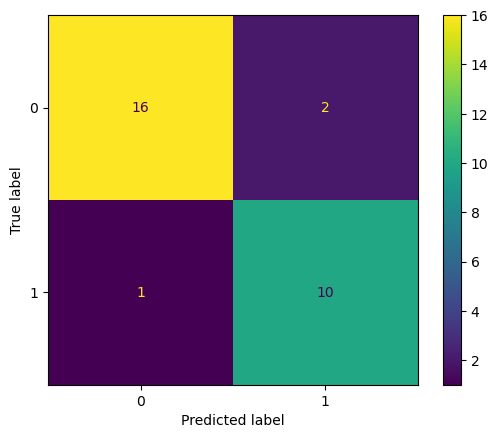

In [13]:
plot_confusion_matrix(rf,embeddings_test,y_test)

# 2: Pretrained Subjective BERT

In [33]:
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,tokenizer="cffl/bert-base-styleclassification-subjective-neutral", max_length=512, truncation=True,
)

loading configuration file https://huggingface.co/cffl/bert-base-styleclassification-subjective-neutral/resolve/main/config.json from cache at /home/gwan/.cache/huggingface/transformers/bfd5c33143b50c6ac113ae1968fc7e425a16ce3742d162f9a62dfd88abf5f02f.e087ae233881216059233b1188427f7df0b885b85a39ed1731a2bcbac5c53f20
Model config BertConfig {
  "_name_or_path": "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "SUBJECTIVE",
    "1": "NEUTRAL"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEUTRAL": "1",
    "SUBJECTIVE": "0"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 

In [34]:
result_pretrained = classify(sentences_test.tolist())

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [35]:
bert1_pred_prob = np.zeros(test.shape[0])
for i,x in enumerate(result_pretrained):
    bert1_pred_prob[i] = x[1]['score']

In [36]:
accuracy_score(y_test,np.where(bert1_pred_prob > 0.5, 1, 0))

0.2413793103448276

In [37]:
precision_recall_fscore_support(y_test,np.where(bert1_pred_prob > 0.5, 1, 0), average='binary')

(0.07692307692307693, 0.09090909090909091, 0.08333333333333334, None)

# 3: Fine Tuned Pretrained Model

In [8]:
# data_files = {"train": "train.csv", "test": "test.csv"}
# dataset = load_dataset('csv',data_files=data_files,column_names=['text','labels'])
from datasets import Dataset
import datasets
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
all_dataset = Dataset.from_pandas(all_data)

In [9]:
task='sentiment'
MODEL = "cffl/bert-base-styleclassification-subjective-neutral"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

In [11]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_all = all_dataset.map(tokenize_function, batched=True)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
small_train_dataset = tokenized_train.shuffle(seed=42)
small_eval_dataset = tokenized_test.shuffle(seed=42)

In [13]:
train_dataset = tokenized_all.shuffle(seed=42)

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer",save_strategy = 'steps', warmup_steps = 50, num_train_epochs=40,learning_rate = 5e-7,weight_decay = 1e-5)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
trainer.train()# new result

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, index. If text, __index_level_0__, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/gwan/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 270
  Num Epochs = 40
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1360
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DI

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: wan19990901. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: ERROR Failed to sample metric: Not Supported


Step,Training Loss
500,0.558100
1000,0.192400


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1360, training_loss=0.30650253576390885, metrics={'train_runtime': 1603.3924, 'train_samples_per_second': 6.736, 'train_steps_per_second': 0.848, 'total_flos': 2841599397888000.0, 'train_loss': 0.30650253576390885, 'epoch': 40.0})

In [18]:
import wandb
wandb.finish()

train/epoch,▁▇█
train/global_step,▁▇█
train/learning_rate,█▁
train/loss,█▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,25.0
train/global_step,1125


In [21]:
OUTPUT_DIR = 'model/'
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained(OUTPUT_DIR)

Configuration saved in model/config.json
Model weights saved in model/pytorch_model.bin


: 